In [1]:
import os.path as osp
import pickle
import random

import numpy as np
import time
import torch

import lmdb

import numpy as np
from torch.utils.data import Dataset
import torchvision
import kornia
from skimage.color import lab2rgb


from collections import OrderedDict
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
import argparse

# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal

device = 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings("ignore")

In [138]:
import os
import re
import glob
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

def get_image_paths(folder_path, N):
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))  # Use '*.*' to include all file types
    image_paths.sort(key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))
    nested_arrays = [image_paths[i:i+N] for i in range(len(image_paths) - N + 1)]

    return nested_arrays



class SequentialDataset(Dataset):
    def __init__(self, data_path,sequntial_length, transform=None):
        self.data = data_path
        self.sequences=get_image_paths(data_path, sequntial_length)
        self.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Resize((256, 256))])


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        L = []
        ab = []
        for image in sequence:
            img = Image.open(image).convert("RGB")
            img = np.array(img)
            img_lab = rgb2lab(img).astype("float32")  # Converting RGB to L*a*b
            img_lab = self.transforms(img_lab)  # Apply transforms
            L.append(img_lab[[0], ...] / 50. - 1.) # Between -1 and 1
            ab.append(img_lab[[1, 2], ...] / 110.) # Between -1 and 1


        L = torch.stack(L)  
        ab = torch.stack(ab)

        
        return {'L': L, 'ab': ab}

In [139]:
ds=SequentialDataset('../../../ColorNet_Backup/Dataset/ds/blackclover/colored/',5)

In [140]:
ds[-1]['ab'].shape

torch.Size([5, 2, 256, 256])

In [141]:
ds[-1]['L'].shape

torch.Size([5, 1, 256, 256])

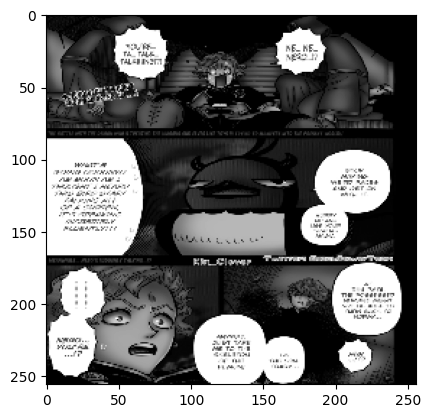

In [143]:
plt.imshow(((ds[0]['L']+1)*50)[0][0],cmap='gray')

In [144]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [146]:
val=lab_to_rgb(ds[0]['L'],ds[0]['ab'])

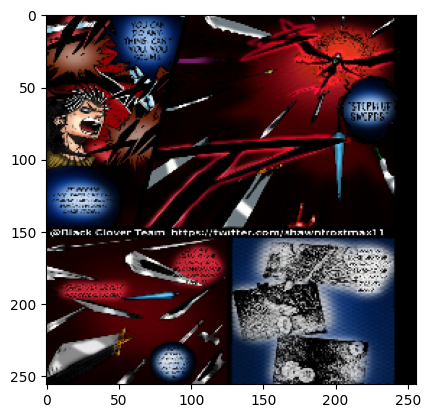

In [152]:
plt.imshow(val[2])